***IMPORT NECESSARY LIBRARIES***

In [1]:
import os, pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier

***IMPORT DATASET***

In [2]:
os.chdir("D:\\VCU Bootcamp\\SCMA\\A3")

In [7]:
df = pd.read_csv('diabetes2.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


***DATA CELANING AND EDA***

In [11]:
# column name have spaces and remove them
df.rename(columns={"Outcome": "Outcome"},inplace = True)

In [12]:
# We can See Dataset is imbalanced
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [13]:
cat_features = df.select_dtypes(include='object')
cat_features.head()

""
0
1
2
3
4


***DATA ENCODING FOR CATEGORICAL VARIABLES***

In [14]:
# encoding category columns
le = LabelEncoder()
encoded_num_df = pd.DataFrame()
for col in cat_features.columns:
    encoded_num_df[col] = le.fit_transform(cat_features[col])

In [16]:
encoded_num_df.head()

""


In [19]:
# final data
f_data = pd.concat([encoded_num_df,df.drop(['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin'],axis=1)],axis=1)
f_data.head()

,BMI,DiabetesPedigreeFunction,Age,Outcome
0,33.6,0.627,50,1
1,26.6,0.351,31,0
2,23.3,0.672,32,1
3,28.1,0.167,21,0
4,43.1,2.288,33,1


***TEST TRAIN SPLIT***

In [20]:
# split data training and testing 
x_train,x_test,y_train,y_test = train_test_split(f_data.drop('Outcome',axis=1),f_data['Outcome'],test_size=0.2,random_state=42)

***SCALING THE DATA***

In [21]:
# scale data to 0 to 1 range 
sc = MinMaxScaler()
sc_x_train = pd.DataFrame(sc.fit_transform(x_train),columns=sc.feature_names_in_)
sc_x_test = pd.DataFrame(sc.fit_transform(x_test),columns=sc.feature_names_in_)

In [22]:
sc_x_train.fillna(sc_x_train.mean(), inplace=True)
mutual_info_scores = mutual_info_classif(sc_x_train, y_train)
feature_scores_df = pd.DataFrame({'Feature': sc_x_train.columns, 'Mutual_Info_Score': mutual_info_scores})
feature_scores_df = feature_scores_df.sort_values(by='Mutual_Info_Score', ascending=False)

***SELECT FEATURES BASED ON FEATURE IMPORTANCE***

In [23]:
# choose 15 top features for model training
selected_features = feature_scores_df.head(15)['Feature'].tolist()
print("Selected Features:", selected_features)

Selected Features: ['BMI', 'Age', 'DiabetesPedigreeFunction']


In [24]:
# Select data with selected features
feature_selection_train = sc_x_train[selected_features]
feature_selection_test = sc_x_test[selected_features]

***FIT LOGISTIC REGRESSION***

In [25]:
# classification report with selected features using LogisticRegression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression(max_iter=200)
logreg.fit(feature_selection_train, y_train)
y_pred = logreg.predict(feature_selection_test)

logrepo= classification_report(y_test, y_pred)
print(logrepo)

              precision    recall  f1-score   support

           0       0.80      0.48      0.60        99
           1       0.46      0.78      0.58        55

    accuracy                           0.59       154
   macro avg       0.63      0.63      0.59       154
weighted avg       0.68      0.59      0.59       154



***ROC CURVE AND AUC VALUE***

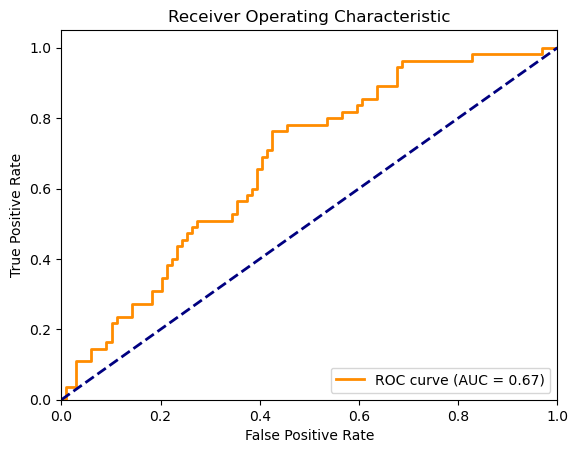

In [26]:
# Get predicted probabilities
y_pred_proba_log = logreg.predict_proba(feature_selection_test)[:, 1]
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_log)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

***CONFUSION MATRIX***

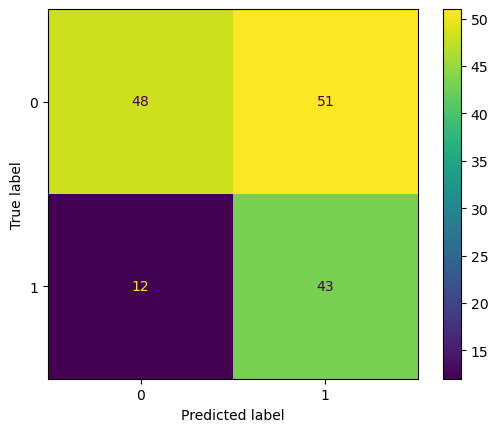

In [27]:
# the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

***DECISION TREE CLASSIFIER***

In [28]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(feature_selection_train, y_train)

# Predict on the test set
y_pred_dt = dt_classifier.predict(feature_selection_test)

# Print classification report
dtree= classification_report(y_test, y_pred_dt)
print(dtree)

              precision    recall  f1-score   support

           0       0.73      0.48      0.58        99
           1       0.42      0.67      0.52        55

    accuracy                           0.55       154
   macro avg       0.57      0.58      0.55       154
weighted avg       0.62      0.55      0.56       154



***ROC CURVE AND AUC VALUE***

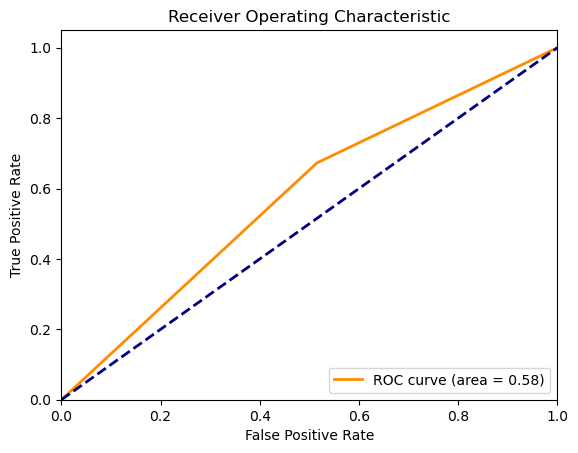

In [29]:
# Get predicted probabilities
y_pred_proba = dt_classifier.predict_proba(feature_selection_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

***CONFUSION MATRIX***

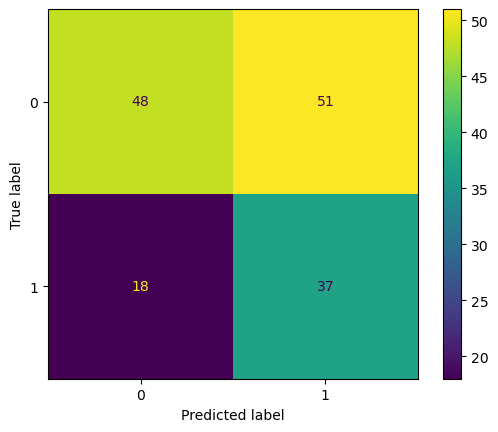

In [30]:
# Compute the confusion matrix
conf_matrix2 = confusion_matrix(y_test, y_pred_dt)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix2)
disp.plot()
plt.show()

In [31]:
import re
def parse_classification_report(report):
    # Split the report by lines
    lines = report.split('\n')
    parsed_data = []
    
    for line in lines[2:-3]:  # Skip headers and footers
        line_data = re.split(r'\s{2,}', line.strip())
        if len(line_data) < 5:
            continue
        class_name = line_data[0]
        precision = float(line_data[1])
        recall = float(line_data[2])
        f1_score = float(line_data[3])
        support = float(line_data[4])
        
        parsed_data.append({
            'class': class_name,
            'precision': precision,
            'recall': recall,
            'f1-score': f1_score,
            'support': support
        })
    
    df = pd.DataFrame(parsed_data)
    return df

In [32]:
df1 = parse_classification_report(dtree)
df2 = parse_classification_report(logrepo)

In [33]:
# Add model names and overall accuracy
df1['model'] = 'Decision Tree'
df2['model'] = 'Logistic Regression'

# Concatenate the two dataframes
comparison_df = pd.concat([df1, df2])

# Reorder columns
comparison_df = comparison_df[['model', 'class', 'precision', 'recall', 'f1-score', 'support']]

# Display the comparison table
print(comparison_df)

                 model class  precision  recall  f1-score  support
0        Decision Tree     0       0.73    0.48      0.58     99.0
1        Decision Tree     1       0.42    0.67      0.52     55.0
0  Logistic Regression     0       0.80    0.48      0.60     99.0
1  Logistic Regression     1       0.46    0.78      0.58     55.0
